# Google Play App Analysis

## Used Packages

```
numpy pandas matplotlib seaborn wordcloud gensim nltk spacy scikit-learn pyLDAvis
```

```
# spacy additional download model
python -m spacy download en_core_web_sm
```

## Data Collecting

- Collected 25,000 reviews from [zoom application](https://play.google.com/store/apps/details?id=us.zoom.videomeetings&hl=en_US&gl=US)
- review date are from 2021-01-12 ~ 2021-07-09 
- Codes are in `./src/collector.py`

In [1]:
import spacy
from spacy import displacy

import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

import pickle
from tqdm.notebook import tqdm
from pathlib import Path
from wordcloud import WordCloud

from gensim.models import TfidfModel, Word2Vec
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

from typing import List, Tuple, Union

import pyLDAvis
import pyLDAvis.gensim_models

from src.utils import *

import matplotlib.font_manager as fm
# need install symbola font to see emoji in wordcloud
# https://fonts2u.com/symbola.font
font_path = [f for f in fm.findSystemFonts() if "Symbola" in f][0]
data_path = Path("./data")

In [2]:
df = pd.read_csv(data_path / "reviews.tsv", sep="\t", encoding="utf-8")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df.sort_values(by="date", ascending=False).reset_index(drop=True)

print(f"Date range: {df['date'].max()} ~ {df['date'].min()}")
df.head()

Date range: 2021-07-09 00:00:00 ~ 2021-01-12 00:00:00


name       date  rate  \
0      Shambhavi Asmit 2021-07-09     2   
1     Bharat wala tech 2021-07-09     2   
2  Divyansh Srivastava 2021-07-09     1   
3         Krishnakanth 2021-07-09     1   
4      Taranpreet Kaur 2021-07-09     5   

                                                text  helpful  
0  Zoom was working just fine till last month but...      990  
1  My network provider is jio and my phone is m21...        0  
2             Zoom is 3 quality app need improvement        0  
3  Before the last update it was good But after t...        0  
4  In zoom I think that their should be a functio...        0

From following `Rate Plot`, we could know Zoom application in Anriod have more positive review than negative reviews.

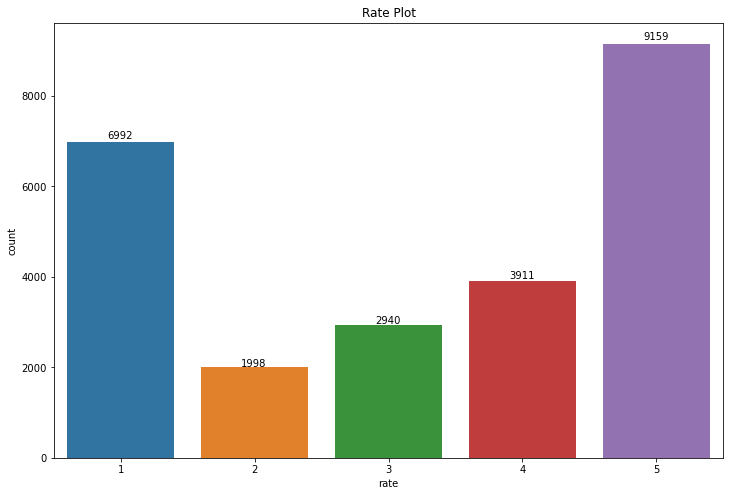

In [3]:
draw_rate_plot(df, title="Rate Plot")

<br>

Preprocess all data to tokens using `spacy` packages, all tokens will be `Token` instance. After that remove puncutations, stopwords and replace number to special \[NUM\] tokens. Two kinds of stopwords are used, (1) only remove punctuations(`[",", ".", "PUNCT"]`) using attribute `pos_` or `tag_` in each token (2) remove all stopwords using `is_stop` attribute of each token. 

Finally save the tokens with combinations of 2 features: (1) select normal text `token` or lemmatization of token `lemma`(all lower case), (2) two kinds of part of speech tagging `pos` or `tag`

- pos: coarse-grained tags, https://universaldependencies.org/docs/u/pos/
- tag: fine-grained part-of-speech tags in SpaCy

<details>
<summary>Preprocessing Function Codes</summary>

```python

get_info = lambda x: (x.lower_, x.lemma_.lower(), x.pos_, x.tag_, x.is_stop)

def process_num_tkns(x: tuple):
    x_lower, x_lemma, x_pos, x_tag = x
    if (x_pos == "NUM") or (x_tag == "CD"):
        return ("[num]", "[num]", x_pos, x_tag)
    else:
        return (x_lower, x_lemma, x_pos, x_tag)
    
def process_remove_s(x: str):
    return x.replace('"', "").replace("-", "")

def preprocessing(txt: spacy.tokens.doc.Doc, stopwords: Union[bool, list]):    
    # tokenize & remove punctuations
    if isinstance(stopwords, bool):
        tkns = [get_info(tkn)[:-1] for tkn in txt if not ((tkn.is_stop) or (tkn.pos_ in ["PUNCT"]) or (tkn.tag_ in [",", "."]))]
    else:
        # specify the stopwords
        tkns = [get_info(tkn)[:-1] for tkn in txt if not ((tkn.tag_ in stopwords) or (tkn.pos_ in stopwords))]
    
    # change NUM to special token [num]
    tkns = [process_num_tkns(x) for x in tkns]
    return tkns

def preprocessing_pipeline(spacy_nlp, df, filename, save=False):
    if save:
        with (data_path / filename).open("wb") as file:
            pickle.dump(list(df["text"].apply(process_remove_s).apply(spacy_nlp)), file)
        return None
    else:
        with (data_path / filename).open("rb") as file:
            doc_data = pickle.load(file)
        return doc_data
    
def get_tokens(doc_data):
    tkns = []
    stopwords = [",", ".", "PUNCT"]
    for text in tqdm(doc_data, total=len(doc_data), desc=f"stopwords: {stopwords}"):
        tkns.append(preprocessing(text, stopwords=stopwords))

    tkns_remove_stop = []
    for text in tqdm(doc_data, total=len(doc_data), desc="stopwords: spacy reference"):
        tkns_remove_stop.append(preprocessing(text, stopwords=True))
    return tkns, tkns_remove_stop
```
</details>

<br>


<details>
<summary>Save Data Codes</summary>


```python

def join_tkn_func(x: tuple, idx1: int, idx2: int):
    """
    idx1: token(0) or lemma token(1)
    idx2: pos(2) or tag(3)
    
    - pos: coarse-grained tags, https://universaldependencies.org/docs/u/pos/
    - tag: fine-grained part-of-speech tags
    """
    return f"{x[idx1]}__{x[idx2]}"

def save2documents(tkns: List[Tuple[str]], sv_path: Union[str, Path], idx1: int, idx2: int):
    """
    tkns: list of tuple tokens, (token, lemma, pos, tag, is_stop)
    filename: save filename
    idx1: token(0) or lemma token(1)
    idx2: pos(2) or tag(3)
    
    - pos: coarse-grained tags, https://universaldependencies.org/docs/u/pos/
    - tag: fine-grained part-of-speech tags
    """
    sv_path = Path(sv_path)
    filename = sv_path.name
    with (data_path / filename).open("w", encoding="utf-8") as file:
        for doc in tqdm(tkns, total=len(tkns), desc=f"processing: {filename}"):
            print(" ".join([join_tkn_func(tkn, idx1, idx2) for tkn in doc]), file=file)
             
def to_token(txt, spacy_nlp, token=True, pos=True):
    txt = spacy_nlp(txt)
    idx1 = 0 if token else 1
    idx2 = 2 if pos else 3
    tkns = [get_info(t)[:-1] for t in txt]
    tkns = [process_num_tkns(t) for t in tkns]
    return [join_tkn_func(t, idx1, idx2) for t in tkns]

def save2document_all(tkns, tkns_remove_stop, poststr=None):
    poststr = "" if poststr is None else f"_{poststr}"
    save2documents(tkns, f"./data/token_pos{poststr}.txt", 0, 2)
    save2documents(tkns, f"./data/token_tag{poststr}.txt", 0, 3)
    save2documents(tkns, f"./data/lemma_pos{poststr}.txt", 1, 2)
    save2documents(tkns, f"./data/lemma_tag{poststr}.txt", 1, 3)
    save2documents(tkns_remove_stop, f"./data/token_pos_rm_stop{poststr}.txt", 0, 2)
    save2documents(tkns_remove_stop, f"./data/token_tag_rm_stop{poststr}.txt", 0, 3)
    save2documents(tkns_remove_stop, f"./data/lemma_pos_rm_stop{poststr}.txt", 1, 2)
    save2documents(tkns_remove_stop, f"./data/lemma_tag_rm_stop{poststr}.txt", 1, 3)

tokenizer_token_pos = lambda x: to_token(x, spacy_nlp, token=True, pos=True)
tokenizer_token_tag = lambda x: to_token(x, spacy_nlp, token=True, pos=False)
tokenizer_lemma_pos = lambda x: to_token(x, spacy_nlp, token=False, pos=True)
tokenizer_lemma_tag = lambda x: to_token(x, spacy_nlp, token=False, pos=False)
```
</details>

In [ ]:
# Don't need to run following code
spacy_nlp = spacy.load("en_core_web_sm")

## remove underline comment if run first time it will take some time
# preprocessing_pipeline(data_path, spacy_nlp, df, "tkns.pickle", save=True)
doc_data = preprocessing_pipeline(data_path, spacy_nlp, df, "tkns.pickle", save=False)

tkns, tkns_remove_stop = get_tokens(doc_data)

save2document_all(tkns, tkns_remove_stop, poststr=None)

## Pros and Cons

If we want to see the application's pros and cons, we need to know what people are thinking about this app which equals to how people are describing this application. It can be done by extracting `noun` and `adjective` words. 

We'll see what are documents are talking by first seeing whole document and then see them by each user rating.

In [5]:
rates = df["rate"].values
unique_rates, n_sample_rates = np.unique(rates, return_counts=True)
print(unique_rates)
print(n_sample_rates)
lemma_pos_path = Path("./data/lemma_pos_rm_stop.txt")
data = load_data(lemma_pos_path)

[1 2 3 4 5]
[6992 1998 2940 3911 9159]


### Analysis the whole document

<details>
<summary>get_pos_tokens Codes</summary>

```python

def get_pos_tokens(counter, tags, length=15):
    res = {}
    for w, c in counter.most_common():
        word, tag = w.split("__")
        if tag in tags:
            res[word] = c
        if (length > 0) and (len(res) >= length):
            break
    return dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
```
    
</details>

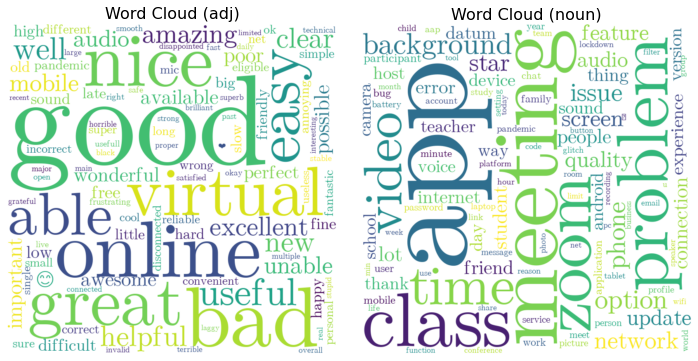

In [6]:
whole_word_count = Counter()
for doc in data:
    whole_word_count.update(doc)
    
length = 100
whole_adj_word_count = get_pos_tokens(whole_word_count, tags=["ADJ"], length=length)
whole_noun_word_count = get_pos_tokens(whole_word_count, tags=["NOUN"], length=length)

whole_clouds = {}
whole_clouds["adj"] = WordCloud(font_path=font_path, width=800, height=800, background_color="white").generate_from_frequencies(whole_adj_word_count)
whole_clouds["noun"] = WordCloud(font_path=font_path, width=800, height=800, background_color="white").generate_from_frequencies(whole_noun_word_count)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for t, ax in zip(["adj", "noun"], axes.flatten()):
    cloud = whole_clouds[t]
    ax.imshow(cloud.to_array(), interpolation="bilinear")
    ax.set_title(f"Word Cloud ({t})", fontsize=16)
    ax.axis(False)
plt.tight_layout()
plt.show()

<br>

From wordcloud figure on the left(adj words), we can see people describe this app using "great", "good", "easy", "useful"... words to talk about the bright side and using "bad", "poor", "annoying" ... words to describe badness of this application. From the right figure(noun words) we can see this app is related to "meeting", "video", "network", "class" ...  words. Also, from words like "error", "issue", we can know some people have some problems(like "network", "connection", "quality", "camera") on this app. 

So we can summarize this application: it's an easy and useful video & audio application on phone, that people(friends or students) are usually using at meeting or class. However, it has some connection and quality issues.

In [7]:
Counter(whole_adj_word_count).most_common(20)

[('good', 7221),
 ('bad', 2324),
 ('online', 2076),
 ('nice', 1912),
 ('great', 1549),
 ('virtual', 1535),
 ('easy', 1223),
 ('able', 1099),
 ('useful', 996),
 ('well', 644),
 ('helpful', 620),
 ('new', 611),
 ('clear', 592),
 ('amazing', 528),
 ('excellent', 505),
 ('mobile', 438),
 ('unable', 425),
 ('audio', 412),
 ('poor', 321),
 ('possible', 320)]

In [8]:
Counter(whole_noun_word_count).most_common(20)

[('app', 14637),
 ('meeting', 6218),
 ('class', 3853),
 ('problem', 3544),
 ('zoom', 3237),
 ('time', 2910),
 ('video', 2703),
 ('background', 2090),
 ('option', 1739),
 ('phone', 1629),
 ('issue', 1550),
 ('star', 1439),
 ('network', 1330),
 ('screen', 1262),
 ('quality', 1106),
 ('update', 1049),
 ('feature', 1039),
 ('audio', 989),
 ('lot', 927),
 ('connection', 902)]

### Analysis by Rating

In [9]:
word_counts = defaultdict(dict)  # {i: Counter() for i in unique_rates}
for r in unique_rates:
    word_counts[r]["counter"] = Counter()
for doc, r in zip(data, rates):
    word_counts[r]["counter"].update(doc)
    
length = -1
for r in unique_rates:
    word_counts[r]["adj"] = get_pos_tokens(word_counts[r]["counter"], tags=["ADJ"], length=length)
    word_counts[r]["noun"] = get_pos_tokens(word_counts[r]["counter"], tags=["NOUN"], length=length)
    
# remove shared words in 5 ratings
adj_arrays = []
noun_arrays = []
for r in unique_rates:
    adj_arrays.append(np.array(list(word_counts[r]["adj"].keys())))
    noun_arrays.append(np.array(list(word_counts[r]["noun"].keys())))
    
for r in unique_rates:
    x = list(range(5))
    x.remove(r-1)
    word_counts[r]["noncommon_adj"] = adj_arrays[r-1][np.concatenate(
        [np.isin(adj_arrays[r-1], adj_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]
    word_counts[r]["noncommon_noun"] = noun_arrays[r-1][np.concatenate(
        [np.isin(noun_arrays[r-1], noun_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]
    
clouds = defaultdict(dict)
length = 100
for r in unique_rates:
    adj_cnt = Counter({w: word_counts[r]["adj"][w] for w in word_counts[r]["noncommon_adj"]}).most_common(length)
    noun_cnt = Counter({w: word_counts[r]["noun"][w] for w in word_counts[r]["noncommon_noun"]}).most_common(length)
    clouds[r]["adj"] = WordCloud(
        font_path=font_path, width=800, height=800, background_color="white", scale=0.9, margin=2,
    ).generate_from_frequencies(dict(adj_cnt))
    clouds[r]["noun"] = WordCloud(
        font_path=font_path, width=800, height=800, background_color="white", scale=0.9, margin=2,
    ).generate_from_frequencies(dict(noun_cnt))


<details>
<summary>draw_wordcloud Codes</summary>

```python

def draw_wordcloud(unique_rates, n_sample_rates, clouds, typ):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for r, n, ax in zip(unique_rates, n_sample_rates, axes.flatten()):
        cloud = clouds[r][typ]
        ax.imshow(cloud.to_array(), interpolation="bilinear")
        ax.set_title(f"{typ.upper()} Word Cloud at rating {r}(n_sample={n})", fontsize=14)
        ax.axis(False)
    axes[-1][-1].axis(False)
    plt.tight_layout()
    plt.show()
```
    
</details>

<br>

From worldclould from following figure(adj words) by each rating, I removed shared words to see what are unique words only appearred in each rating documents. (Purpose: remove the obvious words like "good", "bad"...), but cannot found some intersting words 

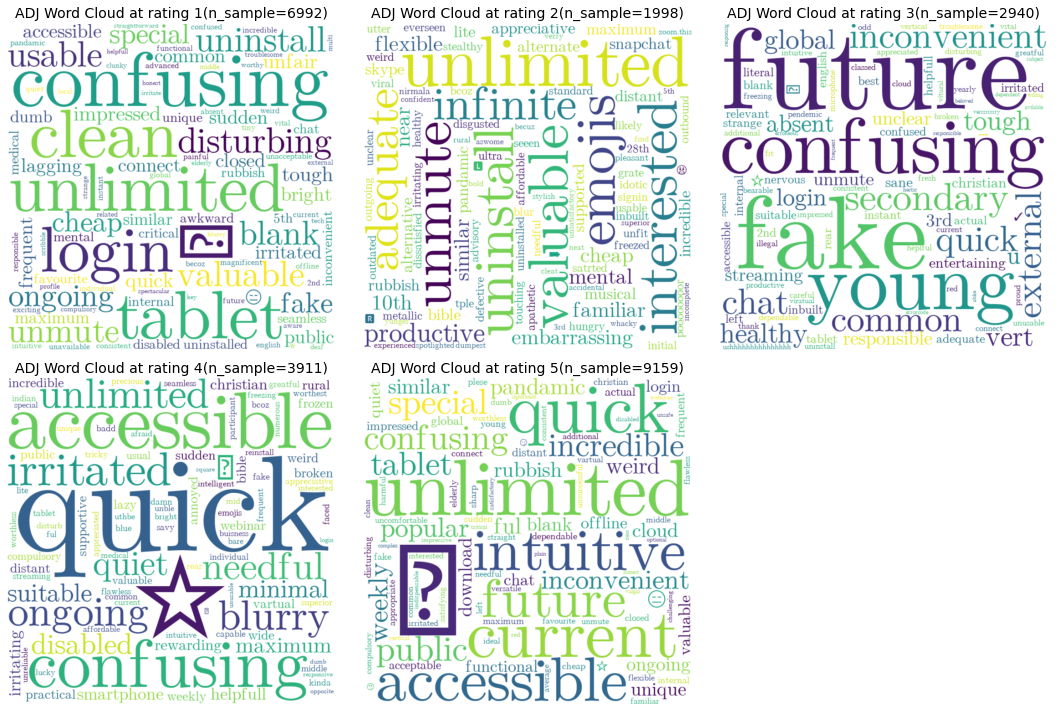

In [10]:
draw_wordcloud(unique_rates, n_sample_rates, clouds, typ="adj")

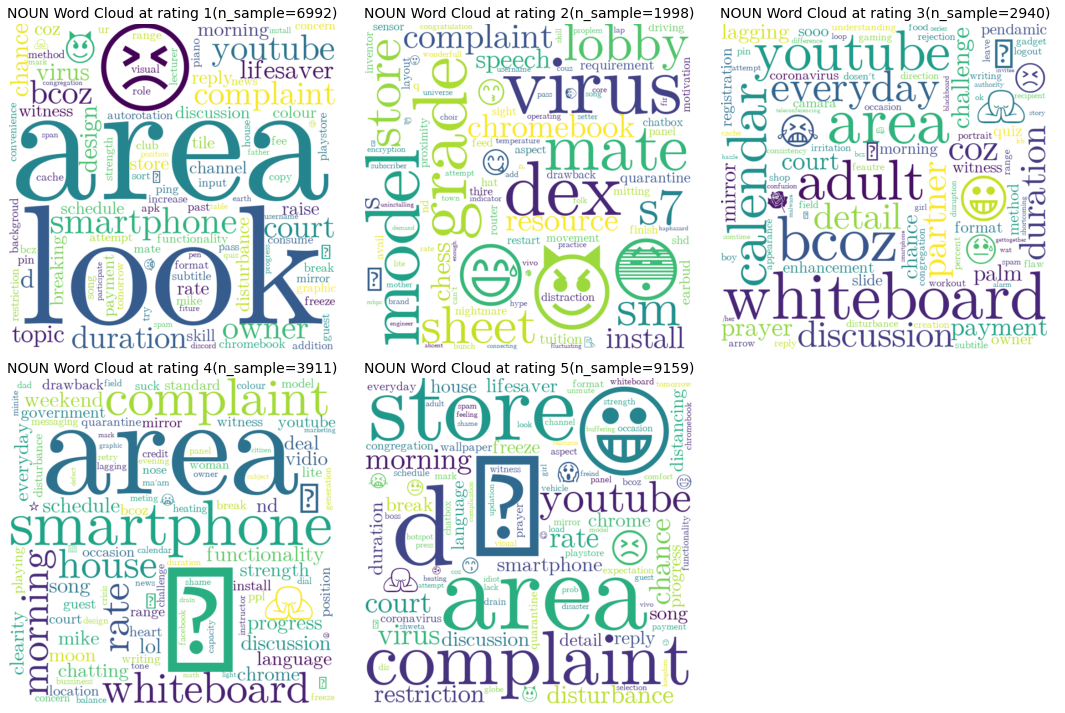

In [11]:
draw_wordcloud(unique_rates, n_sample_rates, clouds, typ="noun")

## Changes before & after update

Found some interesting after recent update the proportion of bad reivew increased

In [12]:
update_date = "2021-06-28"
criteria = df["date"] >= update_date
df_before = df.loc[~criteria, :]
df_after = df.loc[criteria, :]
print(f"Most recent date: {df['date'].max()}")
print(f"Oldest date: {df['date'].min()}")
print(f"Criteria: {update_date}")
print(f"  Review count before: {(~criteria).sum()}")
print(f"  Review count after: {(criteria).sum()}")

Most recent date: 2021-07-09 00:00:00
Oldest date: 2021-01-12 00:00:00
Criteria: 2021-06-28
  Review count before: 20396
  Review count after: 4604


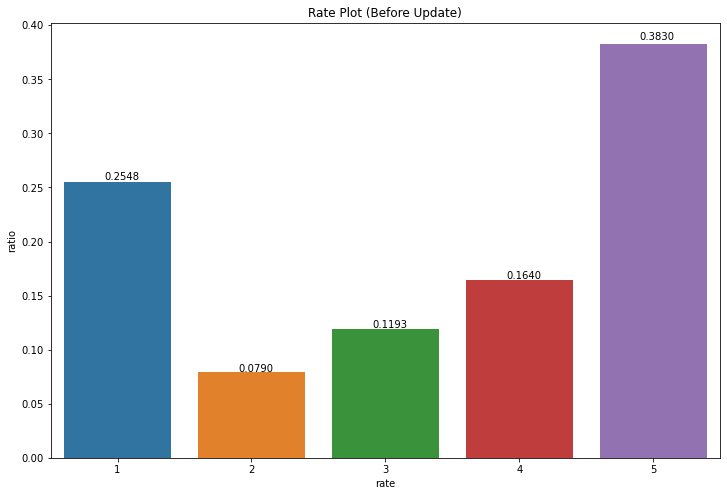

In [13]:
draw_rate_plot(df_before, title="Rate Plot (Before Update)", normalize=True)

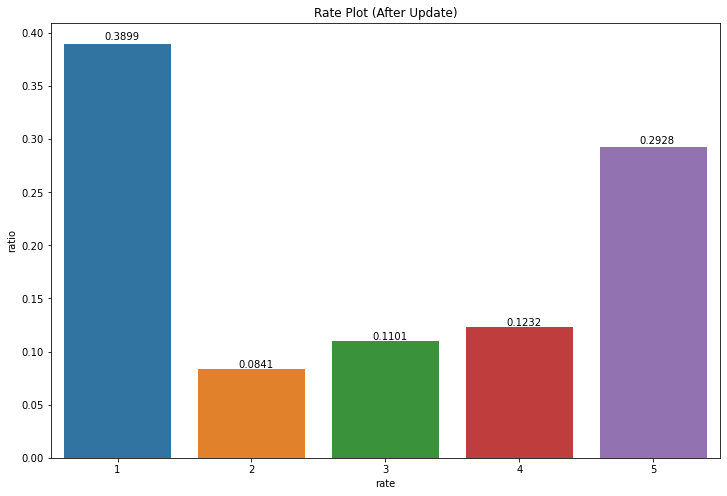

In [14]:
draw_rate_plot(df_after, title="Rate Plot (After Update)", normalize=True)

Since the review size are differentm, we'll see the change of the ratio by each week

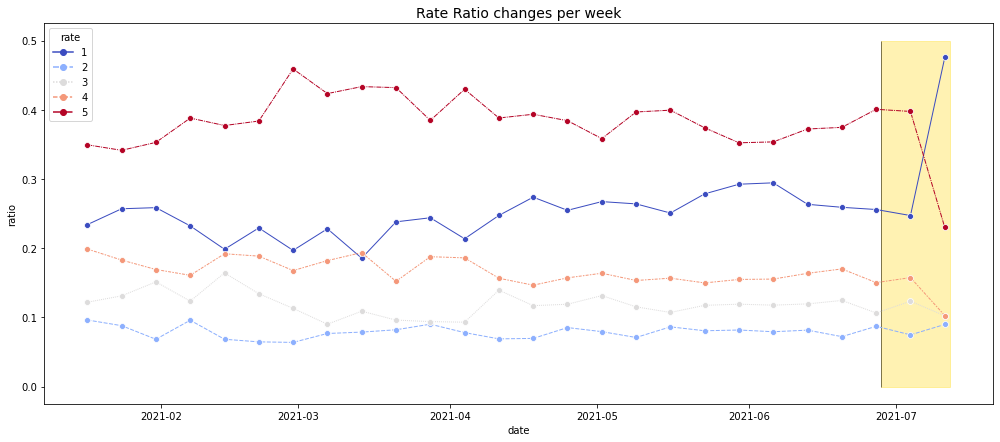

In [15]:
df_changes = df.groupby([pd.Grouper(key="date", freq="W"), "rate"])["rate"].agg(["count"])
df_changes_sum = df_changes.reset_index().groupby([pd.Grouper(key="date", freq="W")])["count"].sum().rename(index="sum")
df_changes = pd.merge(df_changes.reset_index(), df_changes_sum.reset_index(), on="date")
df_changes["ratio"] = df_changes["count"] / df_changes["sum"]

fig, ax = plt.subplots(1, 1, figsize=(17, 7))
sns.lineplot(x="date", y="ratio", hue="rate", data=df_changes, ax=ax, palette="coolwarm", linewidth=1, style="rate", markers=["o"]*5)
ax.set_title(f"Rate Ratio changes per week", fontsize=14)
ax.vlines(x=pd.to_datetime(update_date, format="%Y-%m-%d"), ymin=0.0, ymax=0.5, colors="k", linewidth=0.5)
ax.fill_betweenx(
    y=(0, 0.5), x1=pd.to_datetime(update_date, format="%Y-%m-%d"), x2=pd.to_datetime("2021-07-12", format="%Y-%m-%d"), 
    color="gold", alpha=0.3
)
ax.legend(loc=2, title="rate")
plt.show()

From the figure seems like something happend after recent update

In [16]:
## un comment this code when first run
# preprocessing_pipeline(spacy_nlp, df_before, "tkns_before.pickle", save=True)
# preprocessing_pipeline(spacy_nlp, df_after, "tkns_after.pickle", save=True)

doc_data_before = preprocessing_pipeline(data_path, spacy_nlp, df_before, "tkns_before.pickle", save=False)
doc_data_after = preprocessing_pipeline(data_path, spacy_nlp, df_after, "tkns_after.pickle", save=False)

In [ ]:
# Dont need to run this code
tkns_before, tkns_remove_stop_before = get_tokens(doc_data_before)
tkns_after, tkns_remove_stop_after = get_tokens(doc_data_after)

save2document_all(tkns_before, tkns_remove_stop_before, poststr="before")
save2document_all(tkns_after, tkns_remove_stop_after, poststr="after")

<details>
<summary>get_clouds Codes</summary>

```python

def get_clouds(font_path, unique_rates, n_sample_rates, rates, data):

    word_counts = defaultdict(dict)
    for r in unique_rates:
        word_counts[r]["counter"] = Counter()
    for doc, r in zip(data, rates):
        word_counts[r]["counter"].update(doc)

    length = -1
    for r in unique_rates:
        word_counts[r]["adj"] = get_pos_tokens(word_counts[r]["counter"], tags=["ADJ"], length=length)
        word_counts[r]["noun"] = get_pos_tokens(word_counts[r]["counter"], tags=["NOUN"], length=length)

    # remove common words in 5 ratings
    adj_arrays = []
    noun_arrays = []
    for r in unique_rates:
        adj_arrays.append(np.array(list(word_counts[r]["adj"].keys())))
        noun_arrays.append(np.array(list(word_counts[r]["noun"].keys())))

    for r in unique_rates:
        x = list(range(5))
        x.remove(r-1)
        word_counts[r]["noncommon_adj"] = adj_arrays[r-1][np.concatenate(
            [np.isin(adj_arrays[r-1], adj_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]
        word_counts[r]["noncommon_noun"] = noun_arrays[r-1][np.concatenate(
            [np.isin(noun_arrays[r-1], noun_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]

    clouds = defaultdict(dict)
    length = 100
    for r in unique_rates:
        adj_cnt = Counter({w: word_counts[r]["adj"][w] for w in word_counts[r]["noncommon_adj"]}).most_common(length)
        noun_cnt = Counter({w: word_counts[r]["noun"][w] for w in word_counts[r]["noncommon_noun"]}).most_common(length)
        clouds[r]["adj"] = WordCloud(
            font_path=font_path, width=800, height=800, background_color="white", scale=0.9
        ).generate_from_frequencies(dict(adj_cnt))
        clouds[r]["noun"] = WordCloud(
            font_path=font_path, width=800, height=800, background_color="white", scale=0.9
        ).generate_from_frequencies(dict(noun_cnt))
    
    return {"word_count": word_counts, "adj_arrays": adj_arrays, "noun_arrays": noun_arrays, "clouds": clouds}
```
    
</details>

### Before Update Word Cloud

In [18]:
# df_before
rates = df_before["rate"].values
unique_rates, n_sample_rates = np.unique(rates, return_counts=True)
print(unique_rates)
print(n_sample_rates)
lemma_pos_path = Path("./data/token_pos_rm_stop_before.txt")
data = load_data(lemma_pos_path)
dic_before = get_clouds(font_path, unique_rates, n_sample_rates, rates, data)

[1 2 3 4 5]
[5197 1611 2433 3344 7811]


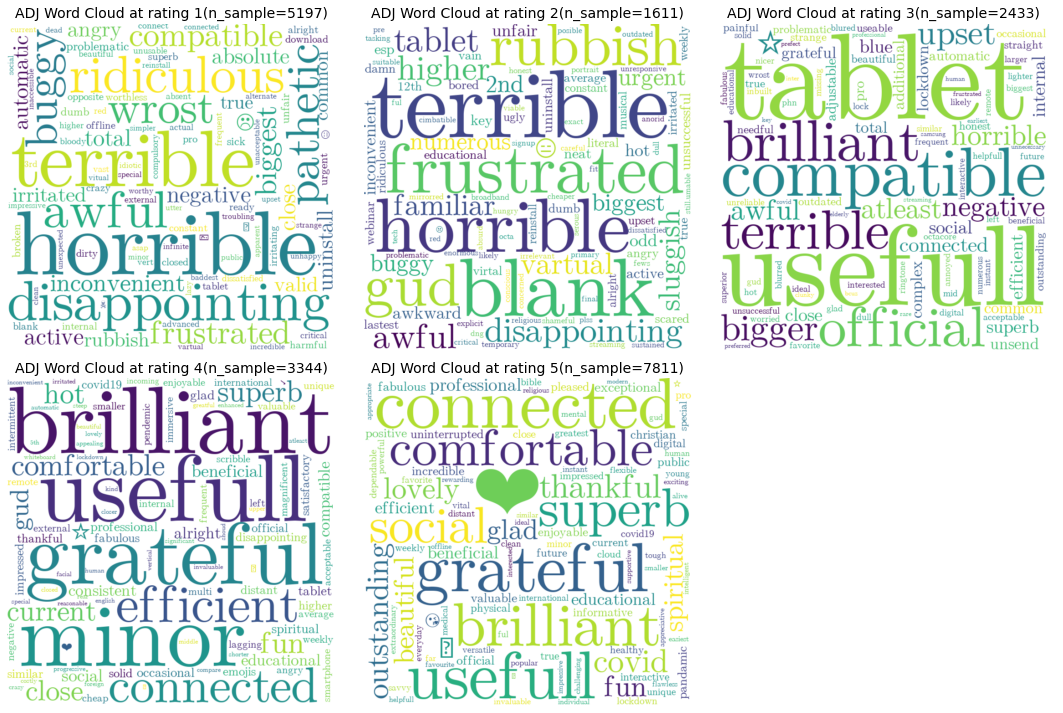

In [19]:
draw_wordcloud(unique_rates, n_sample_rates, dic_before["clouds"], typ="adj")

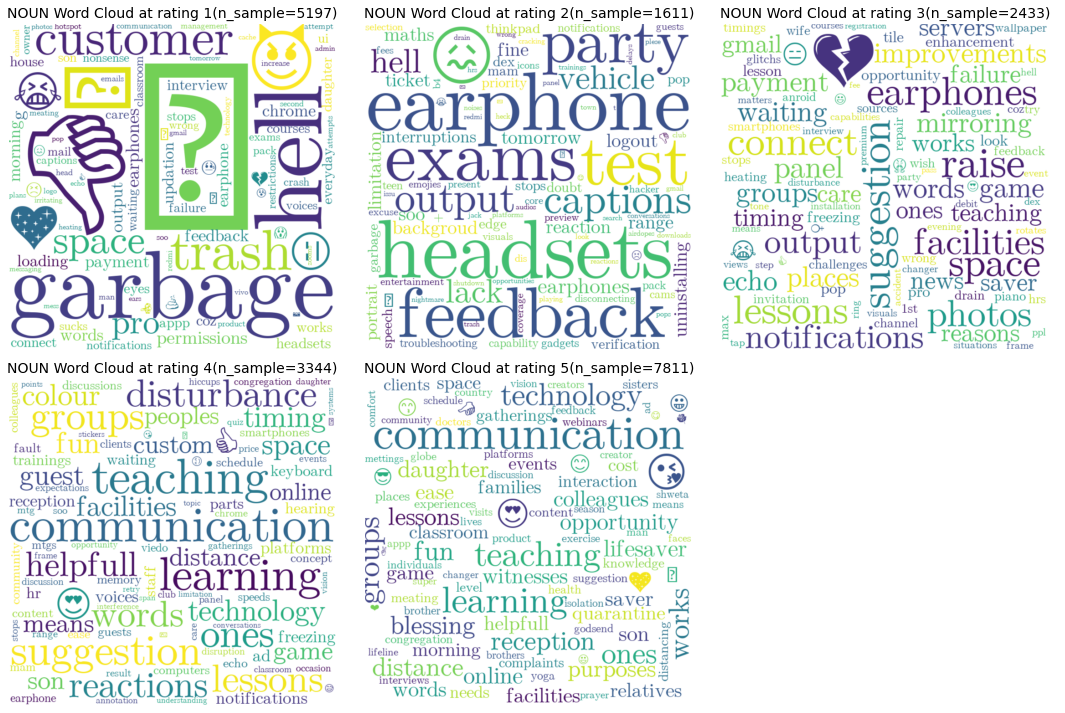

In [20]:
draw_wordcloud(unique_rates, n_sample_rates, dic_before["clouds"], typ="noun")

### After Update Word Cloud

In [21]:
# df_after
rates = df_after["rate"].values
unique_rates, n_sample_rates = np.unique(rates, return_counts=True)
print(unique_rates)
print(n_sample_rates)
lemma_pos_path = Path("./data/lemma_pos_rm_stop_after.txt")
data = load_data(lemma_pos_path)
dic_after = get_clouds(font_path, unique_rates, n_sample_rates, rates, data)

[1 2 3 4 5]
[1795  387  507  567 1348]


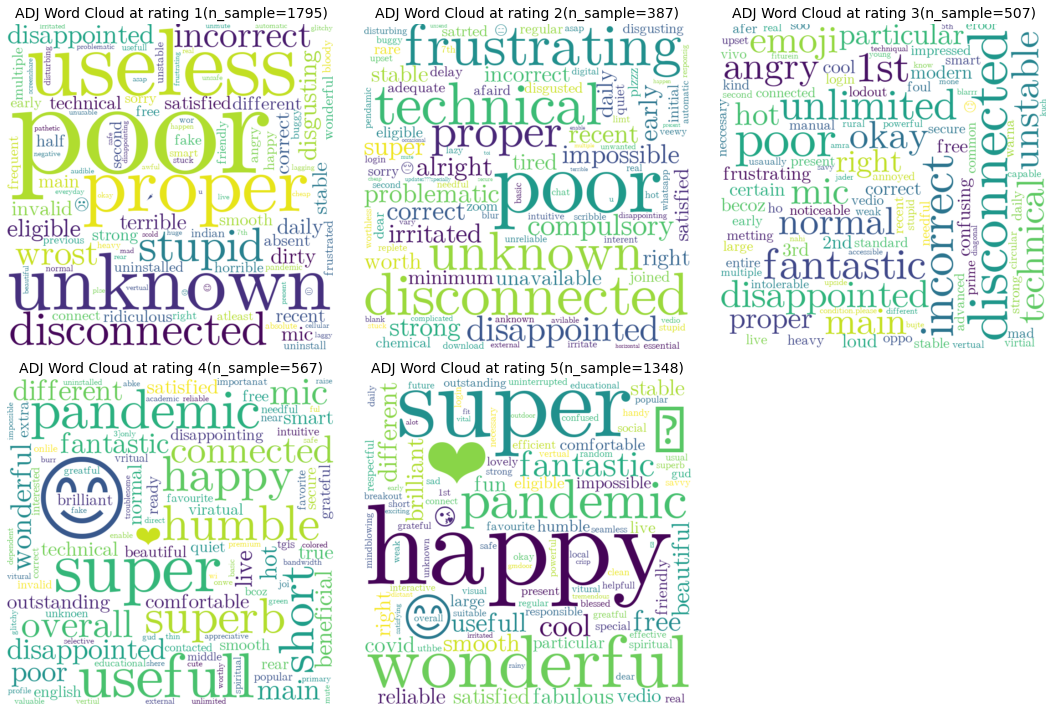

In [22]:
draw_wordcloud(unique_rates, n_sample_rates, dic_after["clouds"], typ="adj")

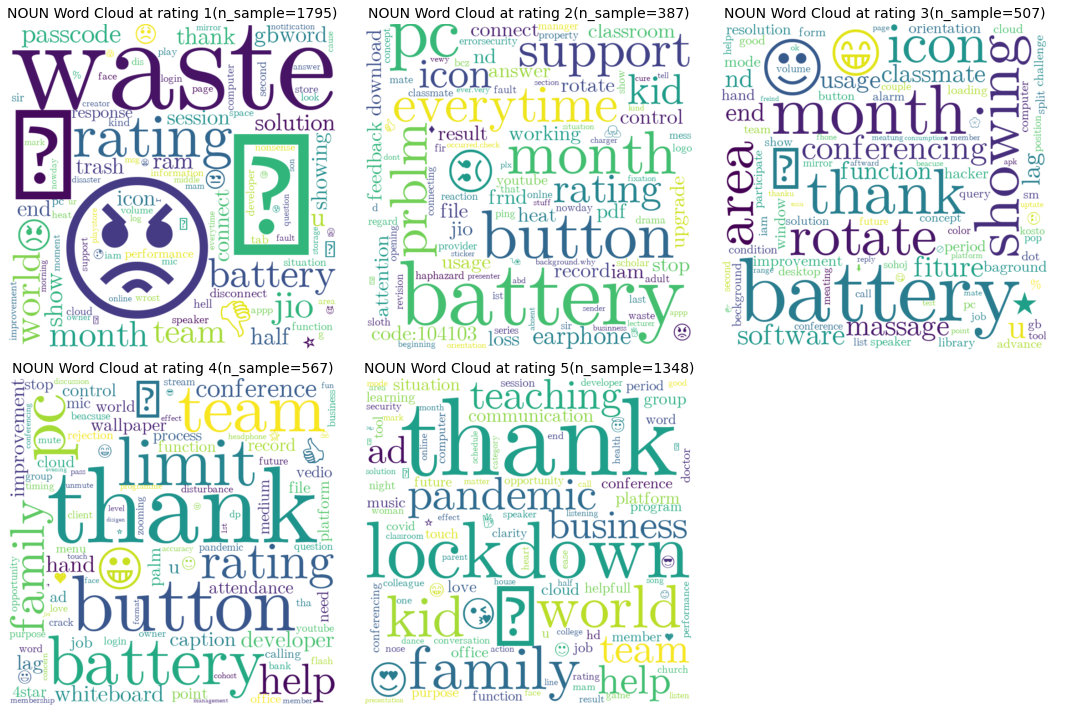

In [23]:
draw_wordcloud(unique_rates, n_sample_rates, dic_after["clouds"], typ="noun")

# LDA

In [25]:
lemma_pos_path = Path("./data/lemma_pos.txt")
data = load_data(lemma_pos_path)

exp_dict = defaultdict(dict)
exp_stopwords = {
    "adj": ["ADJ"], "noun": ["NOUN", "PROPN"], "all": ["ADJ", "NOUN", "PROPN"]
}

for typ in ["adj", "noun", "all"]:
    exp_dict[typ]["data"] = [[tkn.split("__")[0] for tkn in doc if tkn.split("__")[1] in exp_stopwords[typ]] for doc in data]
    exp_dict[typ]["text"] = [" ".join(tkns) for tkns in exp_dict[typ]["data"]]
    dic = Dictionary(exp_dict[typ]["data"])
    print(f"BEFORE FLITER: {typ.upper()} Number of unique tokens: {len(dic)}")
    dic.filter_extremes(no_below=5, no_above=0.5)
    print(f"AFTER FILTER: {typ.upper()} Number of unique tokens: {len(dic)}")
    exp_dict[typ]["vocab"] = dic
    exp_dict[typ]["corpus"] = [exp_dict[typ]["vocab"].doc2bow(line) for line in exp_dict[typ]["data"]]

# calculate coherence values
step = 4
min_topics = 2
max_topics = min_topics + min_topics*step*10

lda_models = defaultdict(dict)

search_space = range(min_topics, max_topics+1, step)
for n_topic in tqdm(search_space, total=len(search_space)):
    for typ in ["adj", "noun", "all"]:
        lda = LdaModel(exp_dict[typ]["corpus"], id2word=exp_dict[typ]["vocab"], num_topics=n_topic)
        cm = CoherenceModel(model=lda, corpus=exp_dict[typ]["corpus"], coherence="u_mass")
        # cm = CoherenceModel(model=lda, texts=exp_dict[typ]["text"], coherence="c_v")  
        lda_models[n_topic][f"{typ}_lda"] = lda
        lda_models[n_topic][f"{typ}_perplexity"] = lda.log_perplexity(exp_dict[typ]["corpus"])
        lda_models[n_topic][f"{typ}_coherence"] = cm.get_coherence()

BEFORE FLITER: ADJ Number of unique tokens: 2387
AFTER FILTER: ADJ Number of unique tokens: 519
BEFORE FLITER: NOUN Number of unique tokens: 8591
AFTER FILTER: NOUN Number of unique tokens: 1438
BEFORE FLITER: ALL Number of unique tokens: 10253
AFTER FILTER: ALL Number of unique tokens: 1893


  0%|          | 0/21 [00:00<?, ?it/s]

### Model Selection

Selected model using perplexity and u-mass coherence

* perplexity: $2^{H(p)}$
    * how model predict precisely, lower better
* u-mass coherence: $\displaystyle C_{UMass} = \dfrac{2}{N*(N-1)}\sum_{i=2}^{N}\sum_{j=1}^{i-1} \log \dfrac{\eta+P(w_i, w_j)}{P(w_i)}$
    * measure the consenumeratency of topic, higher better
    * http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
    * https://datascience.oneoffcoder.com/topic-modeling-gensim.html

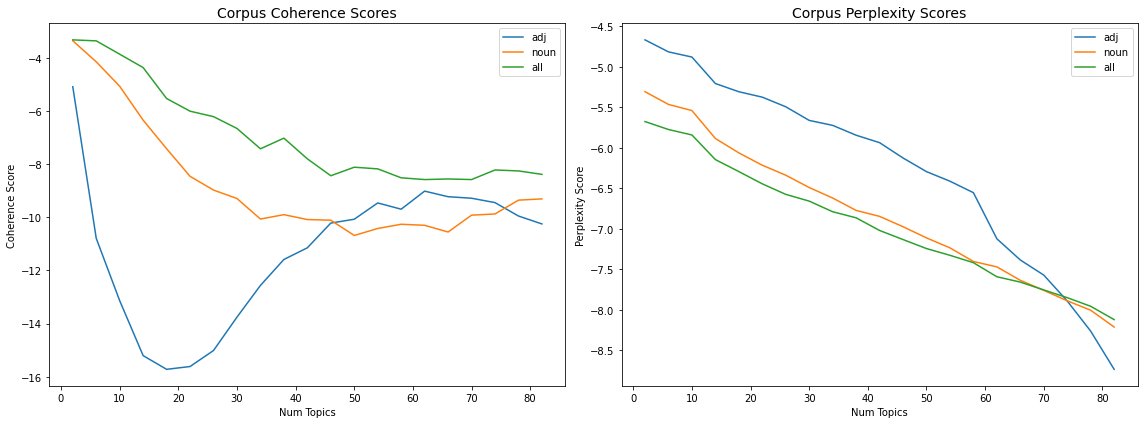

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, ax in enumerate(axes.flatten()):
    score_typ = "Coherence" if i % 2 == 0 else "Perplexity"
    for typ in ["adj", "noun", "all"]:
        ax.plot(np.array(search_space), [lda_models[n_topic][f"{typ}_{score_typ.lower()}"] for n_topic in search_space], label=f"{typ}")
        ax.set_xlabel("Num Topics")
        ax.set_ylabel(f"{score_typ} Score")
        ax.set_title(f"Corpus {score_typ} Scores", fontsize=14)
        ax.legend()
plt.tight_layout()
plt.show()

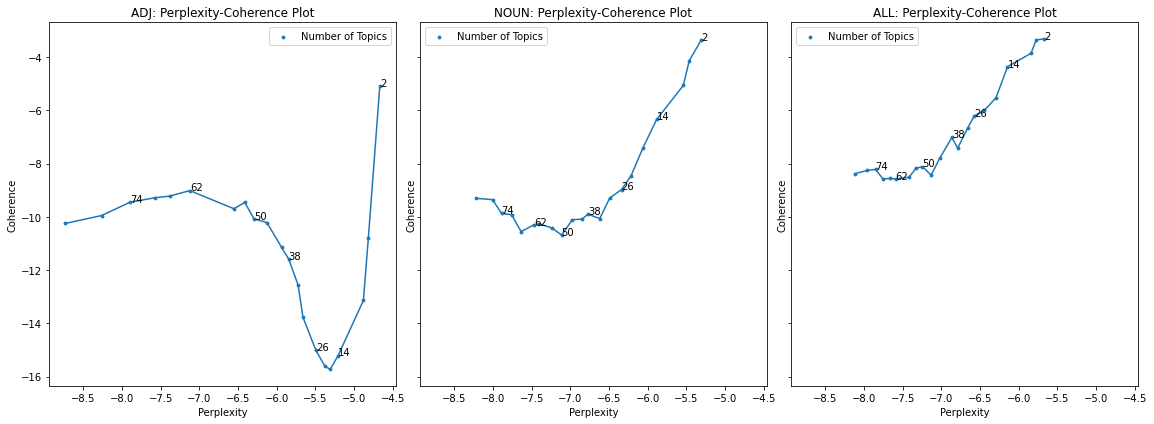

In [27]:
idx = np.arange(0, len(search_space), 3)

fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True, sharex=True)

for ax, typ in zip(axes.flatten(), ["adj", "noun", "all"]):
    co = np.array([lda_models[n_topic][f"{typ}_coherence"] for n_topic in search_space])
    pp = np.array([lda_models[n_topic][f"{typ}_perplexity"] for n_topic in search_space])
    ax.plot(pp, co)
    ax.scatter(pp, co, s=8, label="Number of Topics")
    for i in idx:
        ax.text(pp[i], co[i], s=f"{np.array(search_space)[i]}")
    ax.set_title(f"{typ.upper()}: Perplexity-Coherence Plot")
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Coherence")
    ax.legend()
plt.tight_layout()
plt.show()

In [33]:
print(list(enumerate(search_space)))

[(0, 2), (1, 6), (2, 10), (3, 14), (4, 18), (5, 22), (6, 26), (7, 30), (8, 34), (9, 38), (10, 42), (11, 46), (12, 50), (13, 54), (14, 58), (15, 62), (16, 66), (17, 70), (18, 74), (19, 78), (20, 82)]


In [28]:
## uncomment when first run this code, if you want to save the result
with (data_path / "exp_dict.pickle").open("wb") as file:
    pickle.dump(exp_dict, file)

with (data_path / "lda_models.pickle").open("wb") as file:
    pickle.dump(lda_models, file)

From the figures in Perplexity-Coherence Plot we can choose following models of number of topics

Number of topics:
- ADJ: 50
- NOUN: 26
- ALL: 26

In [44]:
lda_adj = lda_models[54]["adj_lda"]
lda_noun = lda_models[26]["noun_lda"]
lda_all = lda_models[82]["all_lda"]

In [49]:
topics_adj = lda_adj.print_topics(num_topics=20, num_words=5)
for topic in topics_adj:
    print(topic)

(48, '0.394*"important" + 0.243*"last" + 0.199*"slow" + 0.074*"good" + 0.033*"clean"')
(52, '0.665*"other" + 0.126*"first" + 0.104*"good" + 0.032*"invalid" + 0.022*"positive"')
(34, '0.513*"fine" + 0.173*"strong" + 0.111*"normal" + 0.055*"tablet" + 0.053*"extra"')
(44, '0.694*"much" + 0.092*"good" + 0.086*"brilliant" + 0.030*"recent" + 0.028*"cheap"')
(38, '0.609*"awesome" + 0.086*"good" + 0.083*"overall" + 0.075*"unlimited" + 0.035*"angry"')
(17, '0.638*"well" + 0.138*"personal" + 0.102*"good" + 0.039*"disabled" + 0.033*"second"')
(1, '0.657*"helpful" + 0.126*"pandemic" + 0.088*"good" + 0.031*"delete" + 0.023*"limited"')
(8, '0.221*"right" + 0.218*"black" + 0.177*"proper" + 0.077*"worth" + 0.062*"rubbish"')
(46, '0.217*"key" + 0.157*"digital" + 0.157*"☹" + 0.078*"complex" + 0.065*"critical"')
(15, '0.447*"net" + 0.191*"beneficial" + 0.146*"good" + 0.078*"😔" + 0.027*"asap"')
(53, '0.324*"perfect" + 0.223*"possible" + 0.190*"reliable" + 0.117*"convenient" + 0.082*"good"')
(2, '0.681*"us

In [50]:
topics_noun = lda_noun.print_topics(num_topics=20, num_words=5)
for topic in topics_noun:
    print(topic)

(5, '0.282*"background" + 0.144*"option" + 0.094*"android" + 0.079*"phone" + 0.058*"app"')
(15, '0.102*"service" + 0.068*"person" + 0.057*"picture" + 0.056*"app" + 0.042*"year"')
(2, '0.242*"zoom" + 0.136*"experience" + 0.096*"app" + 0.047*"profile" + 0.042*"covid"')
(14, '0.113*"chat" + 0.094*"app" + 0.061*"platform" + 0.054*"love" + 0.051*"education"')
(21, '0.131*"update" + 0.112*"app" + 0.090*"meeting" + 0.088*"user" + 0.084*"bug"')
(7, '0.207*"🤬" + 0.149*"phone" + 0.076*"app" + 0.064*"use" + 0.038*"call"')
(4, '0.374*"video" + 0.186*"quality" + 0.102*"app" + 0.046*"audio" + 0.026*"call"')
(8, '0.155*"app" + 0.102*"waste" + 0.090*"😍" + 0.079*"😘" + 0.025*"complaint"')
(19, '0.227*"app" + 0.144*"thank" + 0.088*"lot" + 0.082*"class" + 0.066*"battery"')
(6, '0.154*"app" + 0.149*"datum" + 0.109*"google" + 0.094*"meet" + 0.047*"😡"')
(25, '0.171*"friend" + 0.124*"way" + 0.102*"aap" + 0.090*"family" + 0.083*"app"')
(0, '0.269*"feature" + 0.146*"app" + 0.053*"💩" + 0.027*"background" + 0.023

In [51]:
topics_all = lda_all.print_topics(num_topics=20, num_words=5)
for topic in topics_all:
    print(topic)

(49, '0.085*"tv" + 0.070*"vivo" + 0.068*"app" + 0.061*"alternative" + 0.052*"bcoz"')
(68, '0.251*"work" + 0.090*"reason" + 0.087*"app" + 0.069*"microphone" + 0.058*"lag"')
(78, '0.225*"super" + 0.121*"app" + 0.095*"open" + 0.078*"sure" + 0.052*"note"')
(3, '0.178*"app" + 0.175*"amazing" + 0.071*"child" + 0.063*"happy" + 0.049*"good"')
(21, '0.251*"️" + 0.119*"slow" + 0.086*"session" + 0.068*"app" + 0.067*"data"')
(79, '0.266*"aap" + 0.178*"wonderful" + 0.062*"late" + 0.056*"good" + 0.055*"stable"')
(48, '0.160*"year" + 0.150*"internet" + 0.078*"app" + 0.067*"meeting" + 0.050*"terrible"')
(15, '0.159*"l" + 0.114*"app" + 0.077*"comment" + 0.070*"saver" + 0.060*"life"')
(31, '0.199*"🏻" + 0.132*"purpose" + 0.092*"app" + 0.068*"good" + 0.055*"pls"')
(35, '0.180*"d" + 0.165*"i" + 0.063*"app" + 0.049*"meeting" + 0.042*"class"')
(7, '0.160*"minute" + 0.103*"meeting" + 0.099*"😡" + 0.091*"app" + 0.078*"time"')
(28, '0.172*"study" + 0.156*"zoom" + 0.114*"good" + 0.099*"app" + 0.075*"communication

**set lambda to 0.6**

the frequency of word "good" is very high, I think this because this word might appear in both rating reviews(like "not good" or "very good") 

In [41]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda_adj, exp_dict["adj"]["corpus"], exp_dict["adj"]["vocab"], sort_topics=False)
pyLDAvis.display(lda_visualization)

From Noun Words Visualization, we can see some negative words are in the quadrant 4(like topic 14, 8, 6), some angry emojis and device words like "pc", "laptop", "galaxy"

In [42]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda_noun, exp_dict["noun"]["corpus"], exp_dict["noun"]["vocab"], sort_topics=False)
pyLDAvis.display(lda_visualization)

In [48]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda_all, exp_dict["all"]["corpus"], exp_dict["all"]["vocab"], sort_topics=False)
pyLDAvis.display(lda_visualization)